In [ ]:
'''
Copyright

Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérejük
az alábbi szerzőt értesíteni.

2021 (c) Csapó Tamás Gábor (csapot kukac tmit pont bme pont hu)


# adatok eredetileg innen:
#   https://www.kaggle.com/mlg-ulb/creditcardfraud/data
# források:
#   https://hub.packtpub.com/using-autoencoders-for-detecting-credit-card-fraud-tutorial/
#   https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd
#   https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6


témakör: anomália detekció ~ outlier detekció ~ kiugró adatok keresése

'''

In [ ]:
# creditcard.csv: hitelkártya fizetési adatok kaggle versenyről

# időnként lassú a letöltés, akár 10p is lehet - időben elkezdeni!
# !wget smartlab.tmit.bme.hu/csapo/dl/creditcard.csv
!wget https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv

In [4]:
!ls -al

total 100256
drwxr-xr-x 1 root root      4096 Nov 17 16:24 .
drwxr-xr-x 1 root root      4096 Nov 17 14:34 ..
drwxr-xr-x 4 root root      4096 Nov  1 13:34 .config
-rw-r--r-- 1 root root 102634230 Nov 17 16:24 creditcard.csv
drwxr-xr-x 2 root root      4096 Nov 17 14:53 .ipynb_checkpoints
drwxrwxr-x 2 root root      4096 Oct 29  2019 __MACOSX
drwxr-xr-x 1 root root      4096 Nov  1 13:35 sample_data


In [5]:
!head creditcard.csv

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807134,-0.072781173,2.536346738,1.378155224,-0.33832077,0.462387778,0.239598554,0.098697901,0.36378697,0.090794172,-0.551599533,-0.617800856,-0.991389847,-0.311169354,1.468176972,-0.470400525,0.207971242,0.02579058,0.40399296,0.251412098,-0.018306778,0.277837576,-0.11047391,0.066928075,0.128539358,-0.189114844,0.133558377,-0.021053053,149.62,0
0,1.191857111,0.266150712,0.166480113,0.448154078,0.060017649,-0.082360809,-0.078802983,0.085101655,-0.255425128,-0.166974414,1.612726661,1.065235311,0.489095016,-0.143772296,0.635558093,0.463917041,-0.114804663,-0.18336127,-0.145783041,-0.069083135,-0.225775248,-0.638671953,0.101288021,-0.339846476,0.167170404,0.125894532,-0.008983099,0.014724169,2.69,0
1,-1.358354062,-1.340163075,1.773209343,0.379779593,-0.503198133,1.800499381,0.791460956,0.247675787,-1.514654323,0.207642865,0.624501459,0.066083685,0.717292731,-0.165

In [6]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [44]:
# adatok beolvasása pandas dataframe-be
df = pd.read_csv('creditcard.csv')

In [45]:
# először nézzük át, mi van az adatokban!

In [46]:
df.shape

(284807, 31)

In [47]:
# V1...V28: tömörített, anonimizált adat
# Time: időbélyeg
# Amount: összeg
# Class: osztály (0: normál, 1: csalás)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [48]:
# van-e benne hiányzó érték
df.isnull().values.any()

False

In [49]:
# normál / csalás tranzakciók aránya
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
print('normál:', normal.shape, 'csalás:', frauds.shape)

normál: (284315, 31) csalás: (492, 31)


In [50]:
# mennyire különböző a normál / csalás tranzakciók összege?
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [51]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

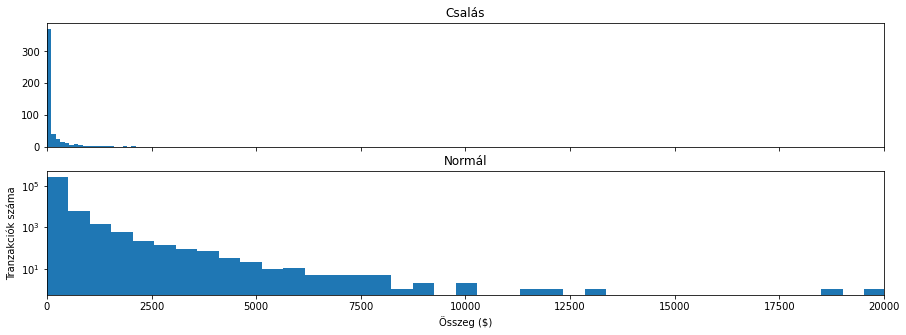

In [52]:
# mennyire különböző a normál / csalás tranzakciók összege?  - hisztogramon ábrázolva
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,5))

ax1.hist(frauds.Amount, bins = 20)
ax1.set_title('Csalás')

ax2.hist(normal.Amount, bins = 50)
ax2.set_title('Normál')
plt.xlabel('Összeg ($)')
plt.ylabel('Tranzakciók száma')
plt.xlim((0, 20000))
plt.yscale('log')

Text(0, 0.5, 'Összeg')

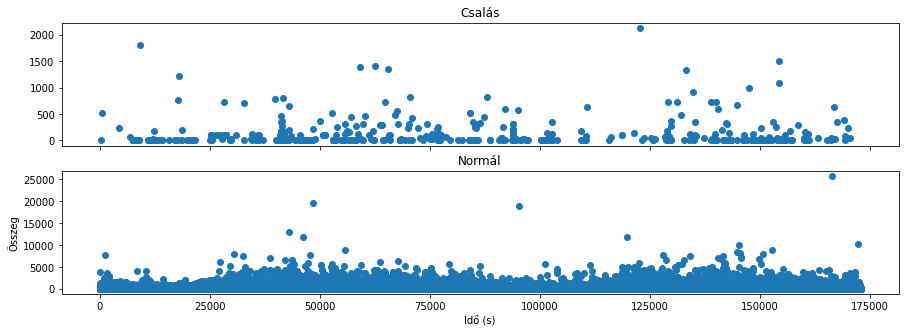

In [53]:
# csalás tranzakciók: látszik valamilyen mintázat időben?
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,5))

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Csalás')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normál')

plt.xlabel('Idő (s)')
plt.ylabel('Összeg')


In [54]:
# adatok átrendezése: időtől nem függ, ezért azt az oszlopot töröljük
df = df.drop('Time',axis=1)

frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [55]:
# csak a normál adatokat vesszük ki, és erre tanítunk majd AE-t
X_normal = normal.drop('Class',axis=1).values

In [56]:
# train-valid-test split
X_normal_train, X_normal_test = train_test_split(X_normal,test_size=0.1)
X_normal_valid, X_normal_test = train_test_split(X_normal_test,test_size=0.5)

X_frauds_test = frauds.drop('Class',axis=1).values

In [57]:
# adatok normalizálása
data_scaler = MinMaxScaler()
X_normal_train = data_scaler.fit_transform(X_normal_train)

X_normal_valid = data_scaler.transform(X_normal_train)
X_normal_test = data_scaler.transform(X_normal_test)
X_frauds_test = data_scaler.transform(X_frauds_test)

In [58]:
X_normal_train.shape, X_normal_valid.shape, X_normal_test.shape, X_frauds_test.shape

((255883, 29), (255883, 29), (14216, 29), (492, 29))

In [59]:
# AE, bottleneck=2 ---> 2D-re tömörítjük az adatokat
data_in = keras.layers.Input(shape=(29,))
encoded = keras.layers.Dense(2,activation='tanh')(data_in)
decoded = keras.layers.Dense(29,activation='sigmoid')(encoded)
autoencoder = keras.models.Model(data_in,decoded)

In [60]:
autoencoder.compile(optimizer='adam',loss='mean_squared_error')

In [61]:
autoencoder.fit(X_normal_train, X_normal_train, epochs = 5, batch_size=128, validation_data=(X_normal_valid,X_normal_valid))

Epoch 1/5
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0064 - val_loss: 8.1967e-04
Epoch 2/5
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0019 - val_loss: 7.1408e-04
Epoch 3/5
2000/2000 [==============================] - 9s 5ms/step - loss: 0.0019 - val_loss: 6.9065e-04
Epoch 4/5
2000/2000 [==============================] - 11s 6ms/step - loss: 0.0019 - val_loss: 6.9536e-04
Epoch 5/5
2000/2000 [==============================] - 9s 5ms/step - loss: 0.0019 - val_loss: 6.2692e-04


In [62]:
# nézzük meg, mit tanul meg az AE a normál tranzakciókról
reconstructions_normal = autoencoder.predict(X_normal_test)

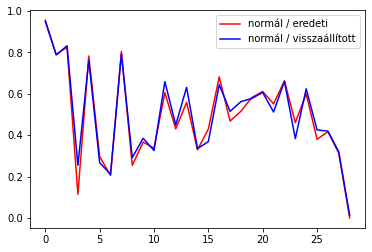

In [67]:
# kirajzolunk egy eredeti és visszaállított adatpontot
plt.plot(X_normal_test[10], 'r')
plt.plot(reconstructions_normal[10], 'b')
plt.legend(['normál / eredeti', 'normál / visszaállított'])

In [65]:
# nézzük meg, mit tanul meg az AE a csalás tranzakciókról
reconstructions_frauds = autoencoder.predict(X_frauds_test)

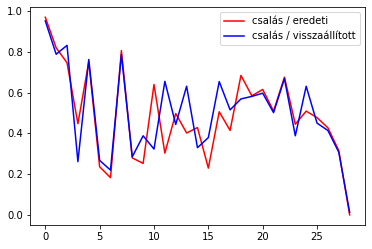

In [68]:
# kirajzolunk egy eredeti és visszaállított adatpontot
plt.plot(X_frauds_test[10], 'r')
plt.plot(reconstructions_frauds[10], 'b')
plt.legend(['csalás / eredeti', 'csalás / visszaállított'])

In [ ]:
# megfigyelés: a 'csalás' tranzakciókat csak nagyobb hibával tudja visszaállítani az AE, mint a normál tranzakcióknál

Text(0, 0.5, 'Tranzakciók száma')

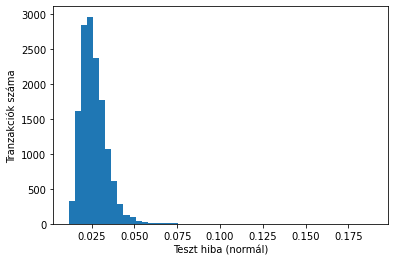

In [69]:
# nézzük meg a visszaállítás hibájának eloszlását a 'normál' tranzakciókon!

reconstructions_normal = autoencoder.predict(X_normal_test)
test_loss = tf.keras.losses.mae(reconstructions_normal, X_normal_test)

plt.hist(test_loss[None,:], bins=50)
plt.xlabel("Teszt hiba (normál)")
plt.ylabel("Tranzakciók száma")

In [71]:
# a fenti ábra alapján úgy tűnik, hogy ha a 'teszt hiba' > 0.05, akkor gyanús az adat
# azaz ezt érdemes a normál / csalás közti küszöb-nek beállítani!

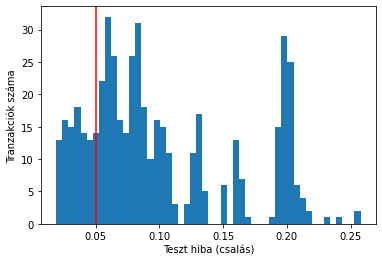

In [73]:
# nézzük meg a visszaállítás hibájának eloszlását a 'csalás' tranzakciókon!

reconstructions_frauds = autoencoder.predict(X_frauds_test)
test_loss = tf.keras.losses.mae(reconstructions_frauds, X_frauds_test)

plt.hist(test_loss[None,:], bins=50)
plt.xlabel("Teszt hiba (csalás)")
plt.ylabel("Tranzakciók száma")

# és tegyük rá az ábrára a fent megállapított a 0.05-ös küszöböt
threshold = 0.05
plt.axvline(threshold, color='r')


In [ ]:
# konklúzió: nagyon egyszerű AE hálózattal sikerült a csalás tranzakciók egy részét felderítenünk!